## Step 1: Installations

In [4]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
autograd is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=2ba700ec261092f384798f37e52d6572ef8c88b24bc03a29ebde7cbfd1de43c0
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [5]:
from lightgbm import LGBMRegressor
import lightgbm as lgb
print("Using LightGBM version",lgb.__version__)

from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost
print("Using XGBoost version",xgboost.__version__)

Using LightGBM version 4.5.0
Using XGBoost version 2.0.3


## Step 2: Load the data

In [6]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
print("Test shape:", test.shape )

train = pd.read_excel("/kaggle/input/cibmtr-2024-dataset/random_folding.xlsx")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 61)


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,fold
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0,42.356,3
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1,4.672,7
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0,19.793,6
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0,102.349,1
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0,16.223,4


## Step 3: EDA

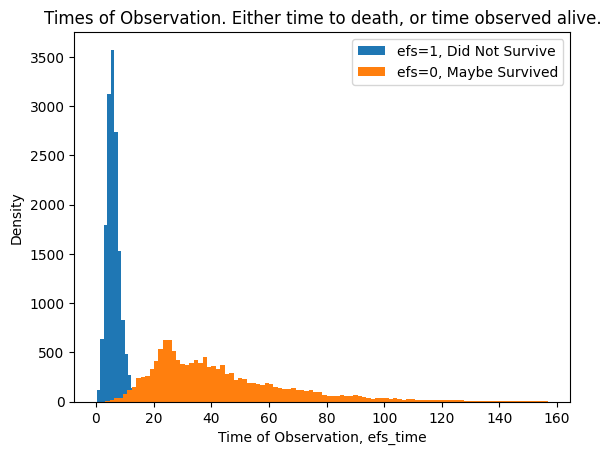

In [7]:
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Did Not Survive")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Survived")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to death, or time observed alive.")
plt.legend()
plt.show()

## Step 4: Transform Two Train Targets into One Target!

In [8]:
from lifelines import NelsonAalenFitter

FOLDS = 10
oof_preds = np.zeros(len(train))
for fold in range(FOLDS):
    train_data = train[train["fold"]!=fold].copy()
    valid_data = train[train["fold"]==fold].copy()
    
    naf = NelsonAalenFitter()
    naf.fit(durations=train_data['efs_time'], event_observed=train_data['efs'])
    
    oof_preds[valid_data.index] = -naf.cumulative_hazard_at_times(valid_data['efs_time']).values

train['y'] = oof_preds 

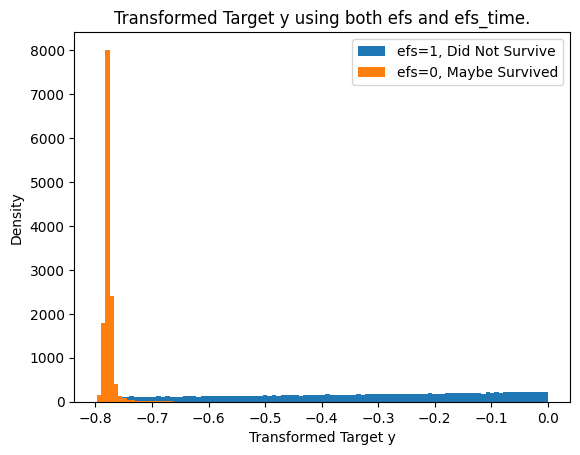

In [9]:
plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Did Not Survive")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Survived")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

## Step 5: Features

In [10]:
RMV = ["ID","efs","efs_time","y", "fold"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


## Step 6: Feature preprocessing

In [11]:
hct_ci_mapping = {
    "arrhythmia": {"No": 0, "Not done": 0, "Yes": 1},  
    "cardiac": {"No": 0, "Not done": 0, "Yes": 1}, 
    "diabetes": {"No": 0, "Not done": 0, "Yes": 1},  
    "hepatic_mild": {"No": 0, "Not done": 0, "Yes": 1},
    "hepatic_severe": {"No": 0, "Not done": 0, "Yes": 3},
    "psych_disturb": {"No": 0, "Not done": 0, "Yes": 1}, 
    "obesity": {"No": 0, "Not done": 0, "Yes": 1}, 
    "rheum_issue": {"No": 0, "Not done": 0, "Yes": 2},
    "peptic_ulcer": {"No": 0, "Not done": 0, "Yes": 2},  
    "renal_issue": {"No": 0, "Not done": 0, "Yes": 2}, 
    "prior_tumor": {"No": 0, "Not done": 0, "Yes": 3}, 
    "pulm_moderate": {"No": 0, "Not done": 0, "Yes": 2}, 
    "pulm_severe": {"No": 0, "Not done": 0, "Yes": 3},  
}


def calculate_hct_ci_score(row, mapping):
    """
    This function calculates the hct_ci score

    Args:
        row (pd.Series): Patient Clinical Data
        mapping (dict): HCT-CI score mapping

    Returns:
        int: HCT-CI score
    """

    score = 0
    if "hepatic_severe" in row and row["hepatic_severe"] == "Yes":
        score += mapping["hepatic_severe"]["Yes"]
    elif "hepatic_mild" in row and row["hepatic_mild"] == "Yes":
        score += mapping["hepatic_mild"]["Yes"]
    if "pulm_moderate" in row and row["pulm_moderate"] == "Yes":
        score += mapping["pulm_moderate"]["Yes"]
    elif "pulm_severe" in row and row["pulm_severe"] == "Yes":
        score += mapping["pulm_severe"]["Yes"]

    # Other Conditions
    for condition, mapping_values in mapping.items():
        if condition not in ["hepatic_mild", "hepatic_severe","pulm_moderate", "pulm_severe"] and condition in row:
            score += mapping_values.get(row[condition], 0)

    return score

In [12]:
# cat2num function is used for mapping some of the Categorical Values into Numerical Values

def cat2num(df):
    df['conditioning_intensity'] = df['conditioning_intensity'].map({
    'NMA': 1, 
    'RIC': 2,
    'MAC': 3,
    'TBD': None,
    'No drugs reported': None,
    'N/A, F(pre-TED) not submitted': None})
    
    df['tbi_status'] = df['tbi_status'].map({
    'No TBI': 0, 
    'TBI +- Other, <=cGy': 1,
    'TBI +- Other, -cGy, fractionated': 2,
    'TBI + Cy +- Other': 3,
    'TBI +- Other, -cGy, single': 4,
    'TBI +- Other, >cGy': 5,
    'TBI +- Other, unknown dose': None})

    df['dri_score'] = df['dri_score'].map({
    'Low': 1, 
    'Intermediate': 2,
    'Intermediate - TED AML case <missing cytogenetics': 3,
    'High': 4,
    'High - TED AML case <missing cytogenetics': 5,
    'Very High': 6,
    'N/A - pediatric': -3,
    'N/A - non-malignant indication': -1,
    'TBD cytogenetics': -2,
    'N/A - disease not classifiable': -4,
    'Missing disease status': 0})
    
    df['cyto_score'] = df['cyto_score'].map({
    'Poor': 4,
    'Normal': 3,
    'Intermediate': 2,
    'Favorable': 1,
    'TBD': -1,
    'Other': -2,
    'Not tested': None})

    df['cyto_score_detail'] = df['cyto_score_detail'].map({
    'Poor': 3, 
    'Intermediate': 2,
    'Favorable': 1,
    'TBD': -1,
    'Not tested': None})
    
    return df

In [13]:
def fill_hla_combined_low(row):
    if np.isnan(row['hla_combined_low']): 
        components = [
            row['hla_match_drb1_low'], row['hla_match_dqb1_low'], 
            row['hla_match_a_low'], row['hla_match_b_low'], row['hla_match_c_low']
        ]
        if all([not np.isnan(x) for x in components]):
            return sum(components)
        else:
            if not np.isnan(row['hla_low_res_8']) and not np.isnan(row['hla_match_dqb1_low']):
                return row['hla_low_res_8'] + row['hla_match_dqb1_low']
            elif not np.isnan(row['hla_low_res_6']): 
                components_6 = [
                    row['hla_match_dqb1_low'], row['hla_match_c_low']
                ]
                if all([not np.isnan(x) for x in components_6]):
                    return row['hla_low_res_6'] + sum(components_6)
                else: 
                    return sum([x for x in components if not np.isnan(x)])
    return row['hla_combined_low'] 

In [14]:
def add_features(df):
    df["hct_ci_score"] = df.apply(lambda row: calculate_hct_ci_score(row, hct_ci_mapping), axis=1)
    df['donor_recipient_age_diff'] = abs(df['donor_age'] - df['age_at_hct'])
    df = cat2num(df)
    df['hla_combined_low'] = df['hla_low_res_10']
    df['hla_combined_low'] = df.apply(fill_hla_combined_low, axis=1)
    df['hla_match_ratio'] = (df['hla_high_res_8'] + df['hla_low_res_8']) / 16
    df['years_since_2000'] = df['year_hct'] - 2000
    df['null_count'] = df.isnull().sum(axis=1)
    df['ci_score_danger'] = df['hct_ci_score'].apply(lambda x: 2 if x >= 3 else 1 if x >= 1 else 0)
    return df

train = add_features(train)
test = add_features(test)

In [15]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 30 CATEGORICAL FEATURES: ['psych_disturb', 'diabetes', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [16]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

# for c in cat2num:
#     combined[c] = combined[c].astype("int32")

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: psych_disturb, diabetes, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [17]:
FEATURES += ["hct_ci_score", 'donor_recipient_age_diff', "hla_combined_low", "hla_match_ratio", 
             "years_since_2000", "null_count","ci_score_danger"]

In [18]:
train.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,fold,y,hct_ci_score,donor_recipient_age_diff,hla_combined_low,hla_match_ratio,years_since_2000,null_count,ci_score_danger
0,0,-1.0,0,NaN,0,NaN,NaN,0.0,0,6.0,0,0,0,0,0,6.0,0,NaN,2.0,0,6.0,2.0,0,2.0,2.0,0,NaN,NaN,0,2016,0,0,0,0,2.0,0,NaN,0,2.0,0,9.942000,2.0,0,0,0,2.0,0,0.0,90.0,0,0,0,0,8.0,0,2.0,0,10.0,0.0,42.356,3.0,-0.775198,0,NaN,10.0,NaN,16,13,0
1,1,2.0,0,2.0,0,2.0,8.0,5.0,0,6.0,1,0,0,0,1,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,1,2.0,3.0,0,2008,0,1,1,1,2.0,0,72.290001,0,2.0,0,43.705002,2.0,1,0,1,2.0,1,3.0,90.0,0,1,1,0,8.0,0,2.0,1,10.0,1.0,4.672,7.0,-0.165767,2,28.585,10.0,1.0,8,0,1
2,2,-1.0,0,NaN,0,2.0,8.0,0.0,0,6.0,0,0,0,0,2,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,0,NaN,NaN,0,2019,0,0,0,0,2.0,0,NaN,0,2.0,0,33.997002,2.0,2,0,2,2.0,0,0.0,90.0,0,1,1,0,8.0,0,2.0,0,10.0,0.0,19.793,6.0,-0.774717,0,NaN,10.0,1.0,19,7,0
3,3,4.0,0,2.0,0,2.0,8.0,0.0,0,6.0,0,0,0,0,3,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,0,2.0,3.0,0,2009,0,1,1,1,2.0,0,29.230000,0,2.0,0,43.244999,2.0,3,0,3,2.0,2,0.0,90.0,1,1,0,0,8.0,0,2.0,0,10.0,0.0,102.349,1.0,-0.783849,1,14.015,10.0,1.0,9,0,1
4,4,4.0,0,NaN,0,2.0,8.0,0.0,0,6.0,1,0,0,0,4,6.0,0,10.0,2.0,0,5.0,2.0,0,2.0,2.0,1,NaN,3.0,1,2018,0,0,0,0,2.0,0,56.810001,0,2.0,0,29.740000,2.0,4,0,0,2.0,3,1.0,90.0,0,1,1,1,8.0,0,2.0,0,10.0,0.0,16.223,4.0,-0.769030,0,27.070,10.0,1.0,18,5,0


In [19]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

FOLDS = 10
    
bin_pred = np.zeros(len(train))
pred_efs = np.zeros(len(test))
models_cls = {}

for fold in range(FOLDS):

    print("#"*25)
    print(f"### Fold {fold+1}")
    print("#"*25)
    
    x_train = train[train['fold']!=fold][FEATURES].copy()
    y_train = train[train['fold']!=fold]["efs"].copy()
    x_valid = train[train['fold']==fold][FEATURES].copy()
    y_valid = train[train['fold']==fold]["efs"].copy()
    x_test  = test[FEATURES].copy()

    model_xgb = XGBClassifier(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.7129400756425178, 
        subsample=0.8185881823156917, 
        n_estimators=20_000, 
        learning_rate=0.04425768131771064,  
        eval_metric="auc", 
        early_stopping_rounds=50, 
        objective='binary:logistic',
        scale_pos_weight=1.5379160847615545,  
        min_child_weight=4,
        enable_categorical=True,
        gamma=3.1330719334577584
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=100
    )

    # INFER OOF (Probabilities -> Binary)
    bin_pred[x_valid.index] = (model_xgb.predict_proba(x_valid)[:, 1] > 0.5).astype(int)
    # INFER TEST (Probabilities -> Average Probs)
    pred_efs += model_xgb.predict_proba(x_test)[:, 1]
    models_cls[fold] = model_xgb

# COMPUTE AVERAGE TEST PREDS
pred_efs = (pred_efs / FOLDS > 0.5).astype(int)

# EVALUATE PERFORMANCE
accuracy = accuracy_score(train["efs"], bin_pred)
f1 = f1_score(train["efs"], bin_pred)
roc_auc = roc_auc_score(train["efs"], bin_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

#########################
### Fold 1
#########################
[0]	validation_0-auc:0.65125


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:14] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.73228
[200]	validation_0-auc:0.74218
[300]	validation_0-auc:0.74725
[400]	validation_0-auc:0.75012
[500]	validation_0-auc:0.75156
[600]	validation_0-auc:0.75231
[700]	validation_0-auc:0.75306
[751]	validation_0-auc:0.75300
#########################
### Fold 2
#########################
[0]	validation_0-auc:0.66049


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:19] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.75204
[200]	validation_0-auc:0.76332
[300]	validation_0-auc:0.76825
[400]	validation_0-auc:0.77037
[500]	validation_0-auc:0.77096
[533]	validation_0-auc:0.77088
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.66892


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:23] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.74642
[200]	validation_0-auc:0.75511
[300]	validation_0-auc:0.75847
[400]	validation_0-auc:0.75886
[402]	validation_0-auc:0.75892
#########################
### Fold 4
#########################
[0]	validation_0-auc:0.66294


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:28] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.73899
[200]	validation_0-auc:0.74758
[300]	validation_0-auc:0.75184
[400]	validation_0-auc:0.75500
[500]	validation_0-auc:0.75748
[600]	validation_0-auc:0.75845
[616]	validation_0-auc:0.75845
#########################
### Fold 5
#########################
[0]	validation_0-auc:0.66656


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:32] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.74523
[200]	validation_0-auc:0.75523
[300]	validation_0-auc:0.75955
[400]	validation_0-auc:0.76250
[500]	validation_0-auc:0.76443
[600]	validation_0-auc:0.76474
[613]	validation_0-auc:0.76497
#########################
### Fold 6
#########################
[0]	validation_0-auc:0.68113


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:37] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.75844
[200]	validation_0-auc:0.76535
[300]	validation_0-auc:0.76818
[400]	validation_0-auc:0.77009
[500]	validation_0-auc:0.77111
[600]	validation_0-auc:0.77152
[605]	validation_0-auc:0.77156
#########################
### Fold 7
#########################
[0]	validation_0-auc:0.66320


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:42] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.73469
[200]	validation_0-auc:0.74520
[300]	validation_0-auc:0.74936
[400]	validation_0-auc:0.75233
[500]	validation_0-auc:0.75375
[587]	validation_0-auc:0.75410
#########################
### Fold 8
#########################
[0]	validation_0-auc:0.65810


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:46] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.72925
[200]	validation_0-auc:0.73803
[300]	validation_0-auc:0.74230
[400]	validation_0-auc:0.74567
[494]	validation_0-auc:0.74668
#########################
### Fold 9
#########################
[0]	validation_0-auc:0.64483


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:50] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.72846
[200]	validation_0-auc:0.73665
[300]	validation_0-auc:0.74009
[400]	validation_0-auc:0.74255
[500]	validation_0-auc:0.74358
[600]	validation_0-auc:0.74423
[664]	validation_0-auc:0.74417
#########################
### Fold 10
#########################
[0]	validation_0-auc:0.64431


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:26:55] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-auc:0.73761
[200]	validation_0-auc:0.74639
[300]	validation_0-auc:0.74992
[400]	validation_0-auc:0.75196
[500]	validation_0-auc:0.75198
[508]	validation_0-auc:0.75213
Accuracy: 0.6741
F1 Score: 0.7453
ROC AUC Score: 0.6562


In [20]:
len(FEATURES)

64

In [24]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer

FOLDS = 10
# Initialize arrays and models
oof_pred = np.zeros(len(train))
pred_final = np.zeros(len(test))
models = {}
best_params = {
    'alpha': 0.0010823961386712318, 
    'max_iter': 1379,
    'solver': 'auto',  # Change solver from 'lbfgs' to 'auto'
}

# Function to transform target values to positive range if needed
def transform_target(y):
    # Add a constant to make all values positive
    min_y = np.min(y)
    if min_y <= 0:
        return y - min_y + 1.0
    return y

def inverse_transform(y):
    # Reverse the transformation
    min_y = np.min(train["y"])
    if min_y <= 0:
        return y + min_y - 1.0
    return y

for fold in range(FOLDS):
    print(f"\nFold {fold+1}/{FOLDS}")
    
    # Data splitting
    train_idx = train[train['fold']!=fold].index
    valid_idx = train[train['fold']==fold].index
    
    x_train = train.loc[train_idx, FEATURES].copy()
    y_train = train.loc[train_idx, "y"].copy()
    x_valid = train.loc[valid_idx, FEATURES].copy()
    y_valid = train.loc[valid_idx, "y"].copy()
    
    # Create imputation pipeline
    imputer = IterativeImputer(max_iter=9, min_value=-12.13711540990779, max_value=99.06385358620167, initial_strategy='mean', random_state=42)
    
    # Use Ridge regression with appropriate solver
    base_model = Ridge(**best_params)
    
    # Use target transformation if needed
    y_min = np.min(y_train)
    if y_min <= 0:
        print(f"Transforming target variable (min value: {y_min})")
        regressor = TransformedTargetRegressor(
            regressor=base_model,
            transformer=FunctionTransformer(transform_target, inverse_transform),
            check_inverse=False  # Explicitly set to False to avoid warning
        )
    else:
        regressor = base_model
    
    model = make_pipeline(
        imputer,
        regressor
    )
    
    # Fit model with imputation
    model.fit(x_train, y_train)
    
    # Store components
    models[fold] = {
        'imputer': imputer,
        'model': model[-1]  # Get the last step in the pipeline
    }
    
    # Generate predictions
    oof_pred[valid_idx] = model.predict(x_valid)
    pred_final += model.predict(test[FEATURES])
    
    # Clean memory
    del x_train, y_train, x_valid, y_valid
pred_final /= FOLDS


Fold 1/10
Transforming target variable (min value: -0.7973310765130597)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(



Fold 2/10
Transforming target variable (min value: -0.7973310765130597)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(



Fold 3/10
Transforming target variable (min value: -0.7973310765130597)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(



Fold 4/10
Transforming target variable (min value: -0.7973310765130597)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(



Fold 5/10
Transforming target variable (min value: -0.7973310765130597)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(



Fold 6/10
Transforming target variable (min value: -0.7973310765130597)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(



Fold 7/10
Transforming target variable (min value: -0.7965391200384344)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(



Fold 8/10
Transforming target variable (min value: -0.7973310765130597)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(



Fold 9/10
Transforming target variable (min value: -0.7973310765130597)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(



Fold 10/10
Transforming target variable (min value: -0.7973310765130597)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(


In [25]:
import pandas as pd
import pandas.api.types
import numpy as np
from lifelines.utils import concordance_index

class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:

    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'predictions'
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []

    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

In [27]:
bin_pred_np = np.array(bin_pred)
oof_ri_np = np.array(oof_pred)

combined_array = np.column_stack((bin_pred_np, oof_ri_np))

In [28]:
combined_array[combined_array[:, 0] == 1, 1] += 0.1

In [29]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["predictions"] = combined_array[:, 1]
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for RI =",m)

<ipython-input-25-029f509416c5>:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for RI = 0.6356244704999544


In [31]:
pred_efs, pred_final

pred_classifier_np = np.array(pred_efs)
prediction_np = np.array(pred_final)

combined_pred = np.column_stack((pred_classifier_np, prediction_np))
combined_pred[combined_pred[:, 0] == 1, 1] += 0.1

combined_pred

array([[ 0.        , -0.63800166],
       [ 1.        , -0.34841979],
       [ 0.        , -0.67547938]])

In [32]:
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = combined_pred[:, 1]
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,-0.638002
1,28801,-0.348420
2,28802,-0.675479


In [33]:
import pickle
with open('tr_exp_06.pkl', 'wb') as f:
    pickle.dump(models, f)

In [34]:
import pickle
with open('tr_exp_06_cls.pkl', 'wb') as f:
    pickle.dump(models_cls, f)

In [35]:
train['predictions'] = combined_array[:, 1]
train.to_parquet("tr_exp_06_oof.parquet")